# Module 8

## Video 35: Hypothesis Testing II
**Python for the Energy Industry**

In this lesson we will look at the statistical tool of Granger causality. Working with the same time series data from the previous lesson, Granger causality allows us to test whether one time series is indeed predictive of the other with a certain time lag.

*Remember: when you run this notebook, you will be using more recent data that was used originally. So, you may find different or even contradictory results! This is the nature of working with real data.*

Start by getting all the data:

In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v

# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

In [2]:
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

china = v.Geographies().search('China',exact_term_match=True)[0]['id']
SEA = v.Geographies().search('Southeast Asia',exact_term_match=True)[0]['id']

SEA_exports = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="loading_end",
    filter_origins=SEA,
    filter_destinations=china,
).to_df()

SEA_exports = SEA_exports.rename(columns={'key':'date','value':'SEA_exp'})[['date','SEA_exp']]

china_imports = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="unloading_start",
    filter_origins=SEA,
    filter_destinations=china,
).to_df()

china_imports = china_imports.rename(columns={'key':'date','value':'china_imp'})[['date','china_imp']]

combined_df = SEA_exports
combined_df['china_imp'] = china_imports['china_imp']

# dropna in case NaN values returned by search
combined_df = combined_df.dropna()

The input to the granger causality test is a numpy array of values, with 2 columns. The test will determine if the second column Granger causes the first. We create two arrays to test both directions of causality:

In [4]:
# test if china imports causes SEA exports
x1 = combined_df[['SEA_exp','china_imp']].values

# test if SEA exports causes china imports
x2 = combined_df[['china_imp','SEA_exp']].values

We'll now do the Granger causality test on x1. We specify the maximum number of lags - this must be less than 1/3 the size of our data. So we go with 15 lags here. The output is a dictionary:

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests

gc1 = grangercausalitytests(x1,maxlag=15,verbose=False)
print(gc1.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [6]:
print(gc1[1])

({'ssr_ftest': (0.11191210577788067, 0.7394982261424798, 46.0, 1), 'ssr_chi2test': (0.11921072137209027, 0.7298921072736446, 1), 'lrtest': (0.11906594393622072, 0.7300497647785229, 1), 'params_ftest': (0.11191210577793151, 0.7394982261424223, 46.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002B329B7BF40>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002B326FF0BE0>, array([[0., 1., 0.]])])


From the test, for each lag, we get the results of a few different types of signficance test. The second value in each of these results tuples is the p-value. So, we pick a test (ssr_ftest), and for each lag value we get the p-value:

In [7]:
test = 'ssr_ftest'
lags = range(1,16)
p1 = [gc1[lag][0][test][1] for lag in lags]
print(p1)

[0.7394982261424798, 0.34406244046901324, 0.4379876250464344, 0.5978693386431604, 0.4297746020366883, 0.5913047894842787, 0.6333656452613916, 0.39251634523943296, 0.3460044222271352, 0.42328369935264354, 0.2947044888072325, 0.4534537474070228, 0.45562416494890623, 0.6404053509496745, 0.6127531951186226]


Clearly, none of these p-values are less than 0.05, so there is no statistically significant evidence of China imports Granger causing SEA exports. We now repeat the test for the other direction of causality, and we plot the p-values for both tests:

<AxesSubplot:>

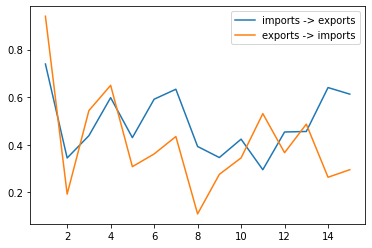

In [8]:
gc2 = grangercausalitytests(x2,maxlag=15,verbose=False)
p2 = [gc2[lag][0][test][1] for lag in lags]

p_df = pd.DataFrame({'imports -> exports':p1,'exports -> imports':p2},index=lags)

p_df.plot()

From this, we can conclude that there is no Granger causation between these two time series.

### Exercise

Using the two time series from the exercise in the previous lesson - confirm that there is no Granger causation.